In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, make_scorer
from itertools import product
%pip install skorch
import skorch
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 16.0 MB/s eta 0:00:00


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, scale=(0.9, 1.1))
])

In [ ]:
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.0kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10, dropout_rate=0.5):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
def train_model(model, epochs, optimizer, criterion, train_loader, val_loader=None):
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss.append(epoch_loss / len(train_loader))

        if val_loader:
            model.eval()
            val_epoch_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.view(inputs.size(0), -1)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_epoch_loss += loss.item()
            val_loss.append(val_epoch_loss / len(val_loader))

        print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}" if val_loader else f"Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}")

    return train_loss, val_loss

In [ ]:
model = MLPClassifier(input_size=28*28, hidden_size=128, num_classes=10).to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
train_loss, val_loss = train_model(model, epochs, optimizer, criterion, train_loader, val_loader)

Epoch 1, Train Loss: 0.5484, Val Loss: 0.2719
Epoch 2, Train Loss: 0.3732, Val Loss: 0.2152
Epoch 3, Train Loss: 0.3273, Val Loss: 0.1872
Epoch 4, Train Loss: 0.3042, Val Loss: 0.1722
Epoch 5, Train Loss: 0.2839, Val Loss: 0.1577
Epoch 6, Train Loss: 0.2748, Val Loss: 0.1530
Epoch 7, Train Loss: 0.2663, Val Loss: 0.1479
Epoch 8, Train Loss: 0.2529, Val Loss: 0.1377
Epoch 9, Train Loss: 0.2482, Val Loss: 0.1289
Epoch 10, Train Loss: 0.2409, Val Loss: 0.1270
Epoch 11, Train Loss: 0.2387, Val Loss: 0.1236
Epoch 12, Train Loss: 0.2343, Val Loss: 0.1240
Epoch 13, Train Loss: 0.2312, Val Loss: 0.1255
Epoch 14, Train Loss: 0.2289, Val Loss: 0.1220
Epoch 15, Train Loss: 0.2224, Val Loss: 0.1216
Epoch 16, Train Loss: 0.2246, Val Loss: 0.1139
Epoch 17, Train Loss: 0.2201, Val Loss: 0.1120
Epoch 18, Train Loss: 0.2187, Val Loss: 0.1116
Epoch 19, Train Loss: 0.2127, Val Loss: 0.1091
Epoch 20, Train Loss: 0.2186, Val Loss: 0.1079


In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.view(inputs.size(0), -1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(all_labels, all_preds))

Accuracy: 0.9698
Precision: 0.9696
Recall: 0.9696
F1-score: 0.9696
Confusion Matrix:
 [[ 969    0    1    0    1    1    3    2    3    0]
 [   0 1122    2    2    0    1    4    1    3    0]
 [   4    1  993    3    5    0    5   14    6    1]
 [   0    0    7  975    0   13    0    9    4    2]
 [   0    0    2    1  943    0    6    4    4   22]
 [   2    1    0   10    1  863    6    1    4    4]
 [   7    3    0    1    3    6  936    0    2    0]
 [   3    8   12    1    1    0    0  990    3   10]
 [   3    2    3    8    6    7    2    5  935    3]
 [   4    3    0    4   12    5    1    3    5  972]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.97 

In [ ]:
torch.save(model.state_dict(), "mlp_classifier_mnist.pth")

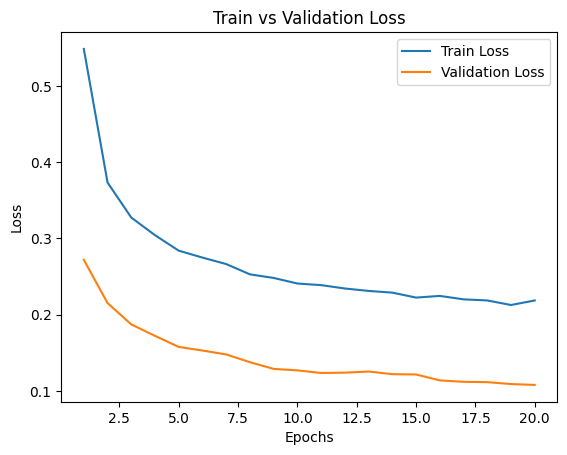

In [ ]:
plt.plot(range(1, epochs+1), train_loss, label="Train Loss")
plt.plot(range(1, epochs+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
net = NeuralNetClassifier(
    MLPClassifier,
    module__input_size=28*28,
    module__num_classes=10,
    max_epochs=8,
    lr=0.001,
    optimizer=torch.optim.SGD,
    criterion=nn.CrossEntropyLoss,
    device=device,
    iterator_train__shuffle=True,
)

In [ ]:
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'optimizer__momentum': [0.6, 0.8, 0.95],
    'batch_size': [32, 64, 128]
}

In [ ]:
train_data = train_dataset.dataset.data[train_dataset.indices].view(-1, 28*28).float().numpy()
train_targets = train_dataset.dataset.targets[train_dataset.indices].numpy()

In [ ]:
gs = GridSearchCV(net, param_grid, refit=True, cv=3, scoring=make_scorer(accuracy_score), verbose=2, n_jobs=-1)
gs.fit(train_data, train_targets)

best_params = gs.best_params_
print(f"Best params: {best_params}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4269       0.9468        0.1779  2.6330
      2        0.2759       0.9540        0.1527  2.8163
      3        0.2342       0.9621        0.1272  2.3487
      4        0.2205       0.9642        0.1188  2.3606
      5        0.2060       0.9643        0.1174  2.3328
      6        0.1946       0.9646        0.1128  2.4939
      7        0.1844       0.9694        0.1028  2.9907
      8        0.1778       0.9670        0.1039  2.4096
Best params: {'batch_size': 32, 'lr': 0.01, 'optimizer__momentum': 0.95}


In [ ]:
net.set_params(**best_params)
net.fit(train_data, train_targets)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4216       0.9420        0.1929  2.6831
      2        0.2835       0.9536        0.1468  2.9812
      3        0.2405       0.9591        0.1351  2.3474
      4        0.2179       0.9625        0.1216  2.3475
      5        0.2063       0.9676        0.1110  2.3323
      6        0.1965       0.9656        0.1105  2.3423
      7        0.1892       0.9678        0.1062  2.9065
      8        0.1826       0.9675        0.1036  2.4323


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MLPClassifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  ),
)

In [ ]:
y_pred = net.predict(test_dataset.data.view(-1, 28*28).float())
y_true = test_dataset.targets.numpy()

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_true, y_pred))

Accuracy: 0.9697
Precision: 0.9697
Recall: 0.9694
F1-score: 0.9695
Confusion Matrix:
 [[ 964    0    2    2    1    4    5    1    1    0]
 [   0 1123    3    2    0    0    2    1    4    0]
 [   1    2 1003    5    6    1    2    8    4    0]
 [   0    0    3  991    0    4    0    7    5    0]
 [   1    1    2    0  939    0    5    1    3   30]
 [   2    1    1   12    1  855    8    1   10    1]
 [   5    3    0    0    6    8  933    0    3    0]
 [   3    9   13    6    0    1    0  985    1   10]
 [   3    2    3    7    3    2    4    7  941    2]
 [   5    5    1   11   10    3    0    8    3  963]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.97      0.96      0.96       982
           5       0.97      0.96 